/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
neptune: Executing in Offline Mode.


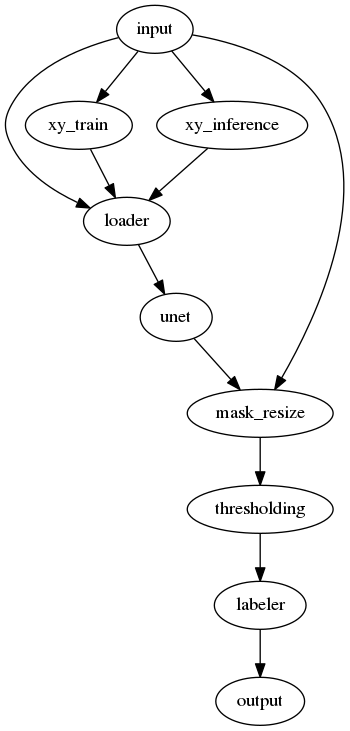

In [1]:
from pipelines import unet_train
from pipeline_config import SOLUTION_CONFIG

pipe = unet_train(SOLUTION_CONFIG)
pipe

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_watershed_pipeline/outputs/thresholding')

In [108]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta.head()

,ImageId,file_path_image,file_path_masks,file_path_mask,is_train,width,height,n_nuclei,file_path_centers,file_path_contours
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,27.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
1,003cee89357d9fe13516167fd67b609a164651b2193458...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,36.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,70.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,86.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,7.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...


/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


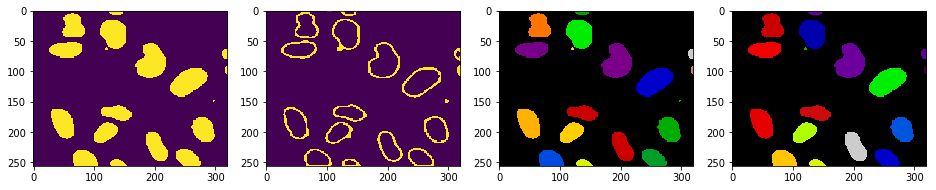

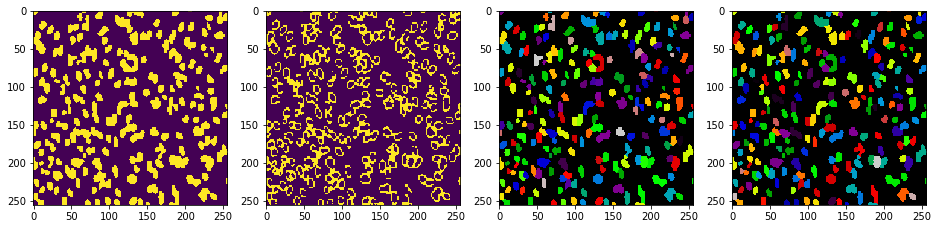

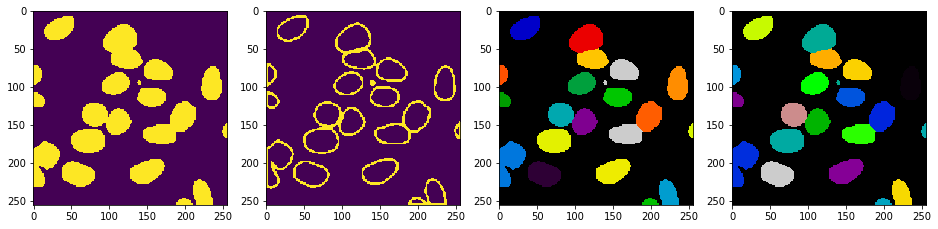

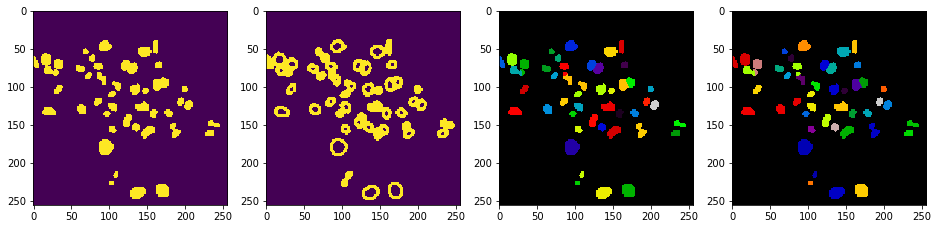

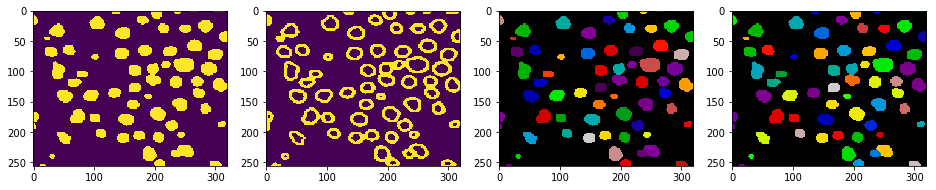

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
from scipy.stats import itemfreq
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/mask_thresholding')
contour_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/contour_thresholding')
watershed_contour = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/watershed_contour')
drop_smaller = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/drop_smaller')


for idx in np.random.choice(range(100),5):
    m = mask_threshold['binarized_images'][idx]
    t = contour_thresholding['binarized_images'][idx]
    w = watershed_contour['detached_images'][idx]
    d = drop_smaller['labels'][idx]
    
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(t) 
    plt.subplot(143)
    plt.imshow(random_colors(w),cmap='spectral')   
    plt.subplot(144)
    plt.imshow(random_colors(d),cmap='spectral')
    plt.show()


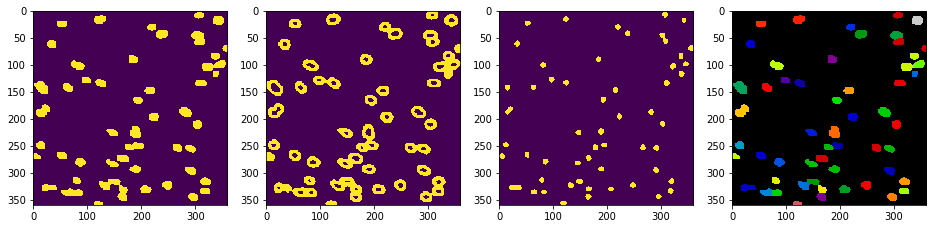

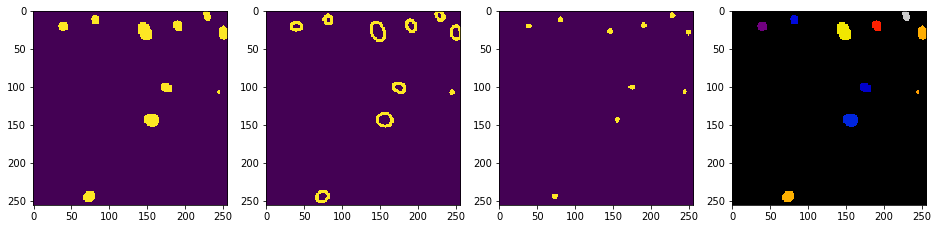

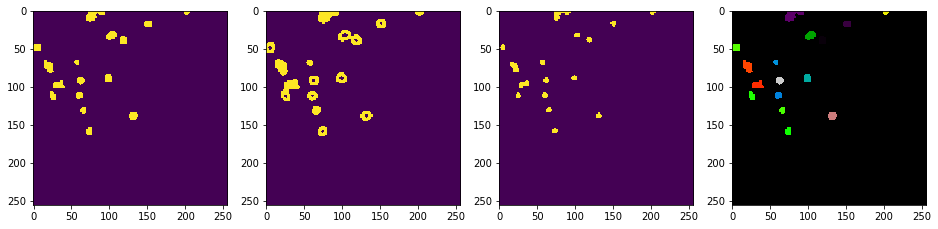

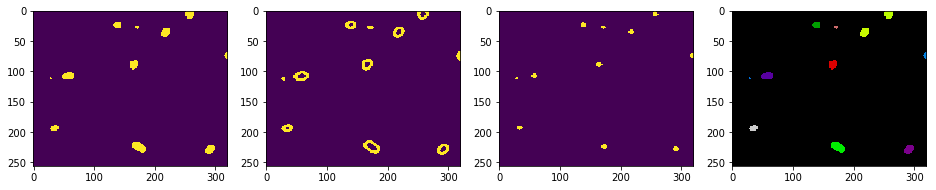

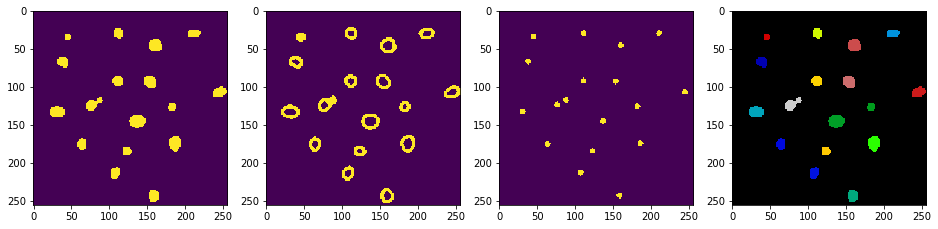

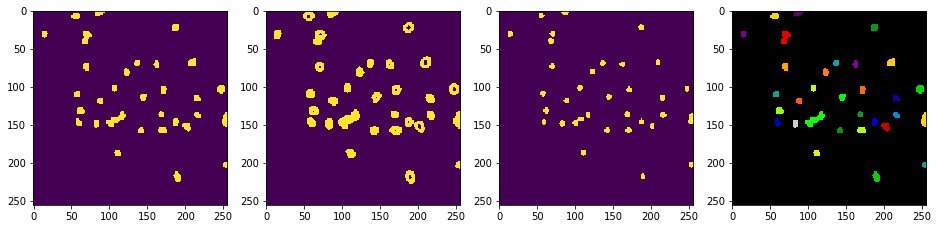

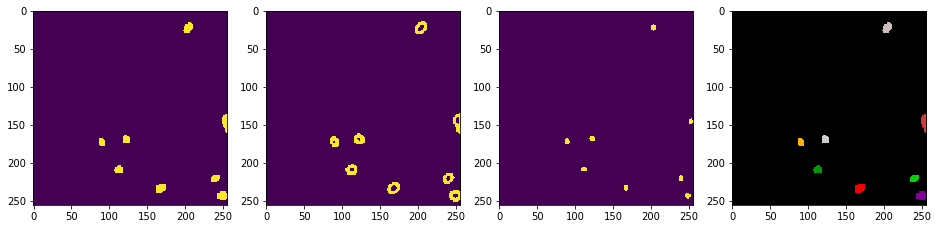

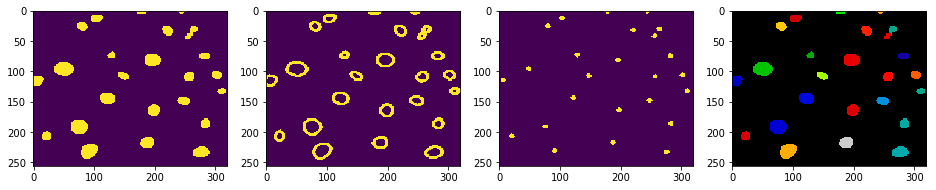

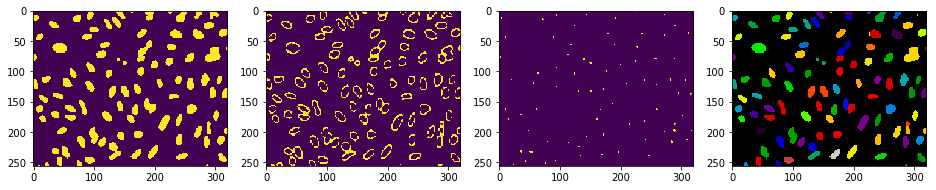

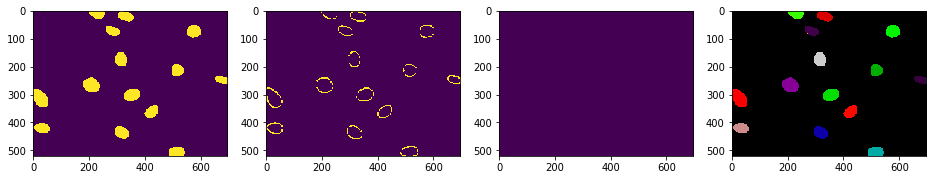

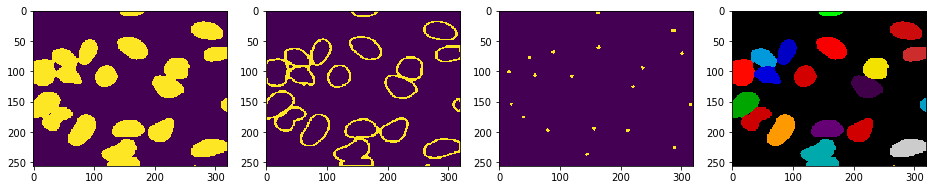

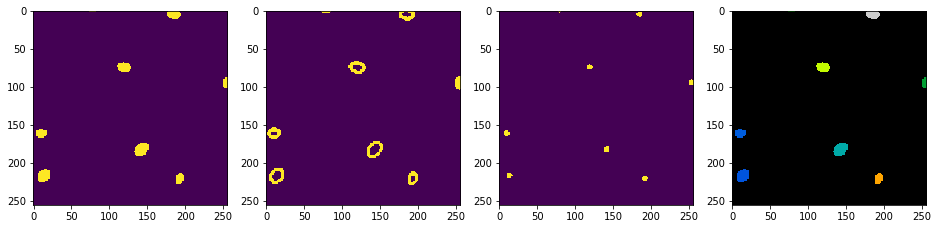

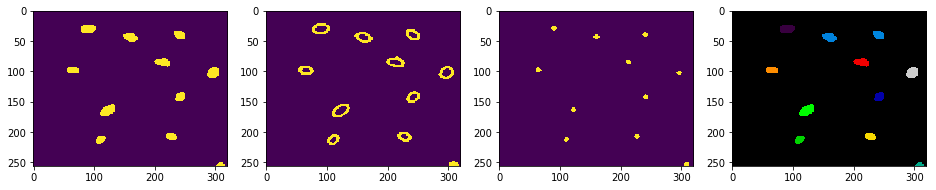

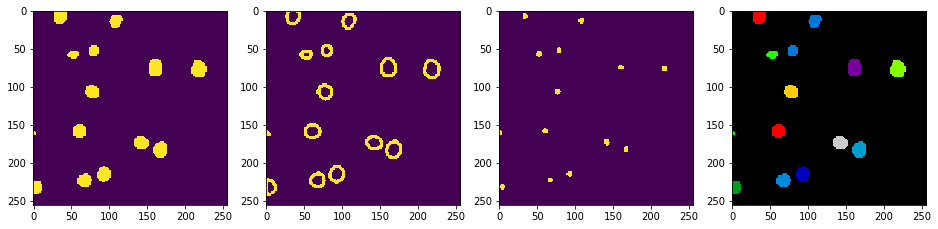

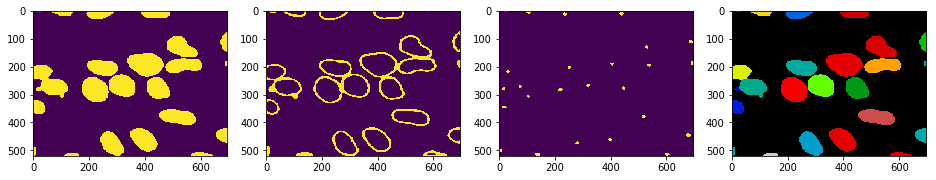

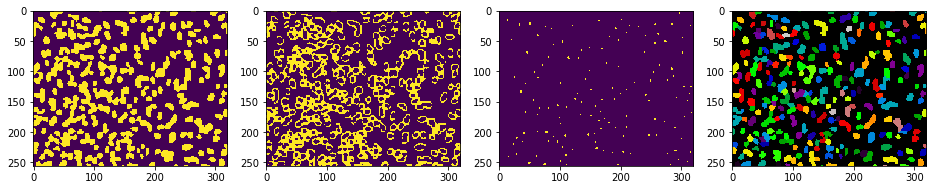

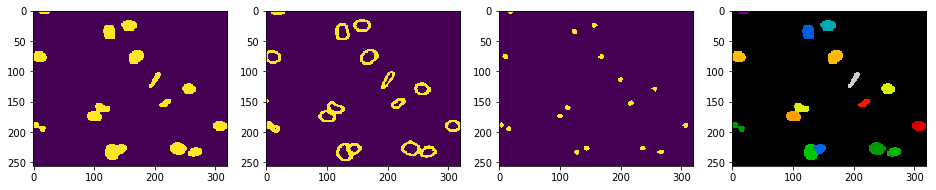

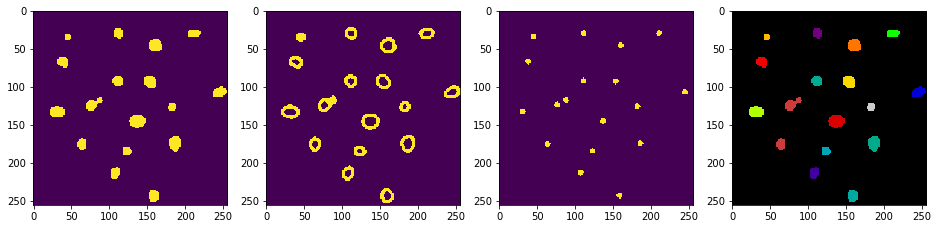

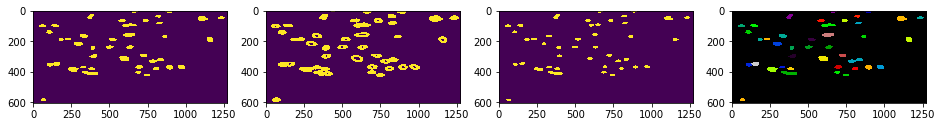

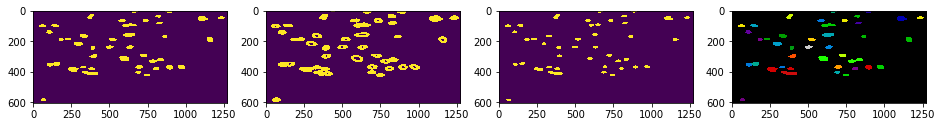

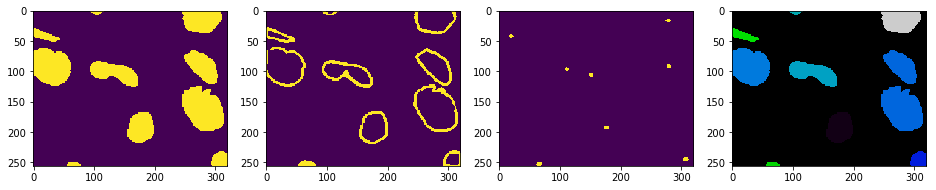

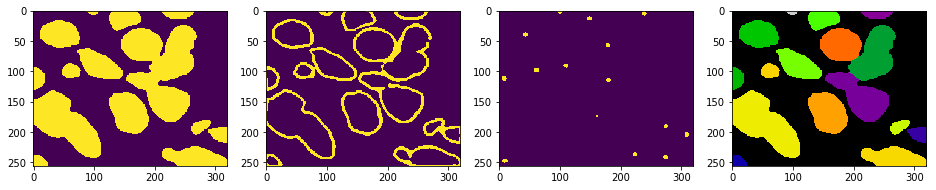

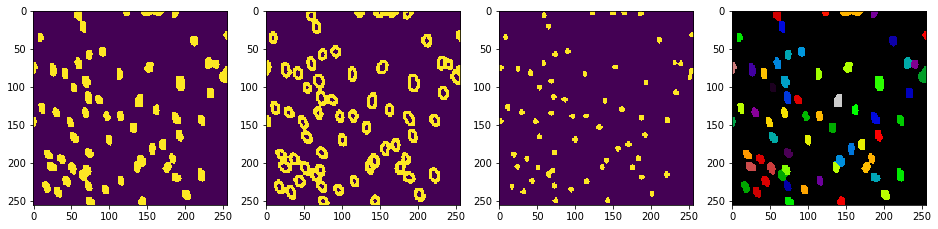

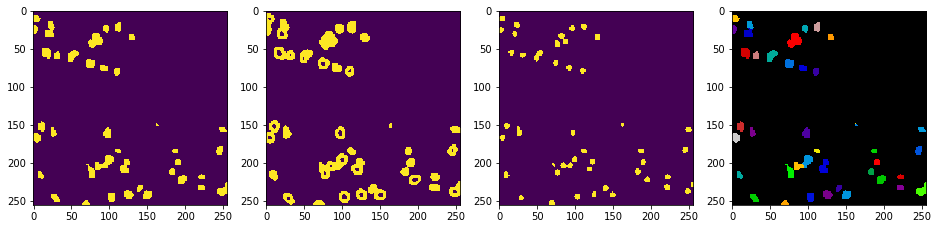

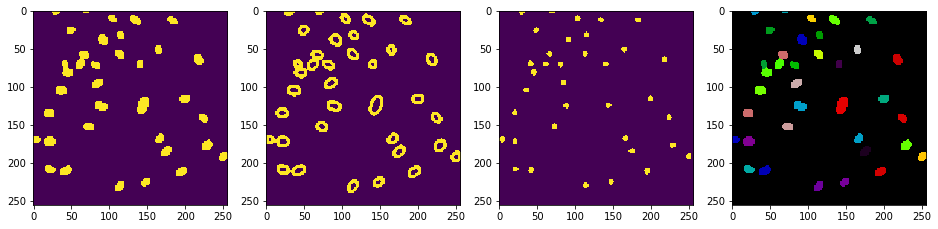

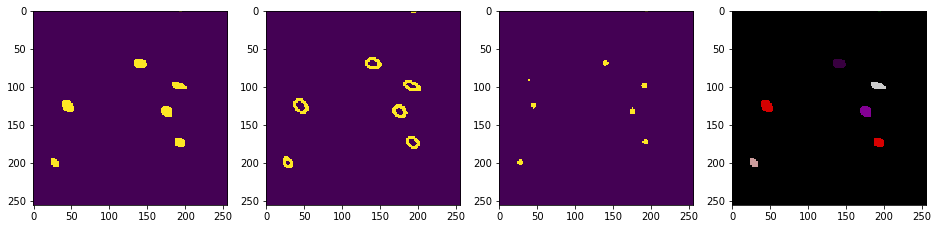

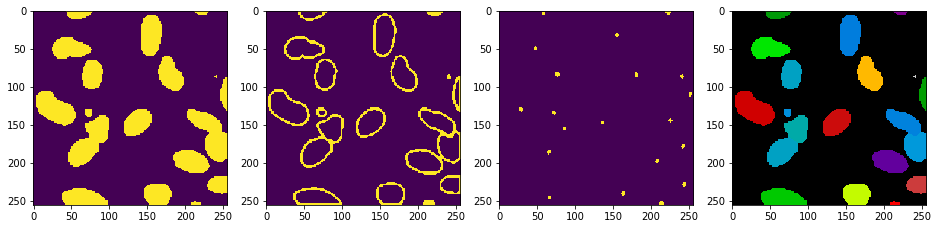

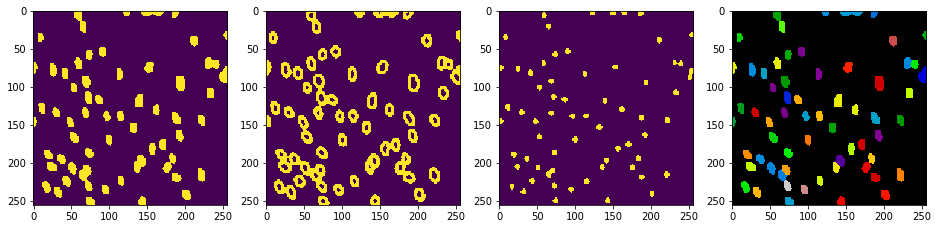

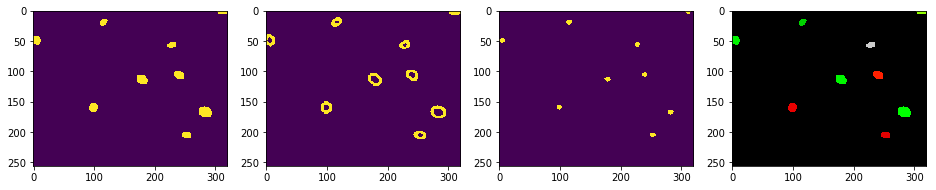

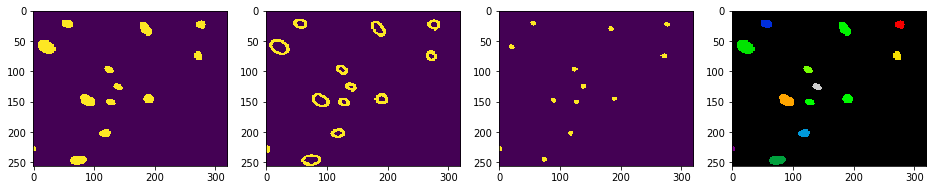

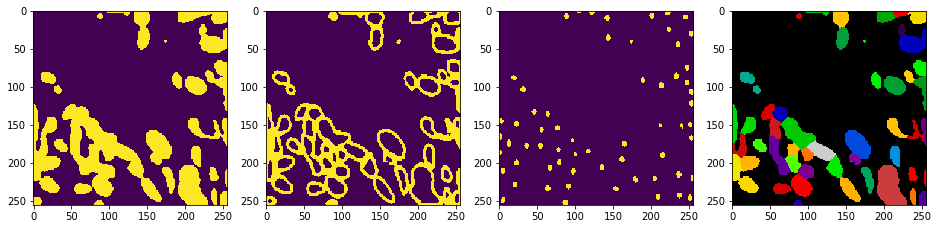

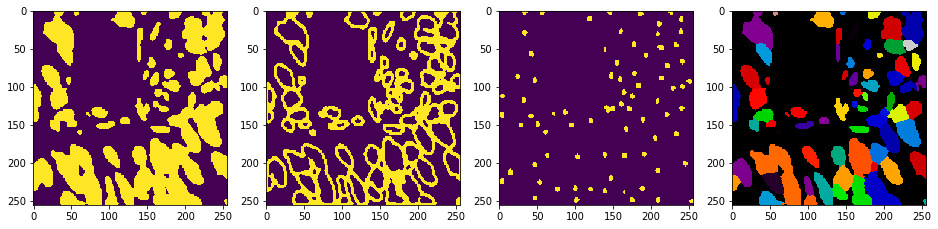

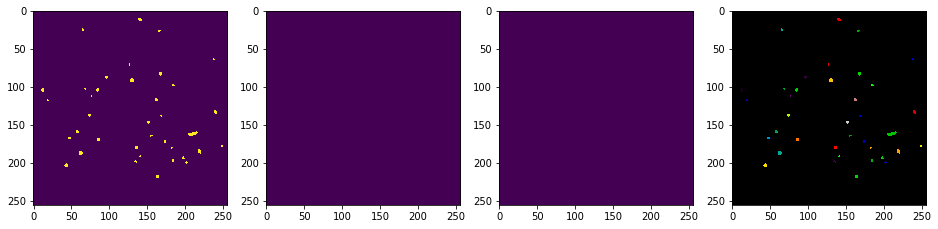

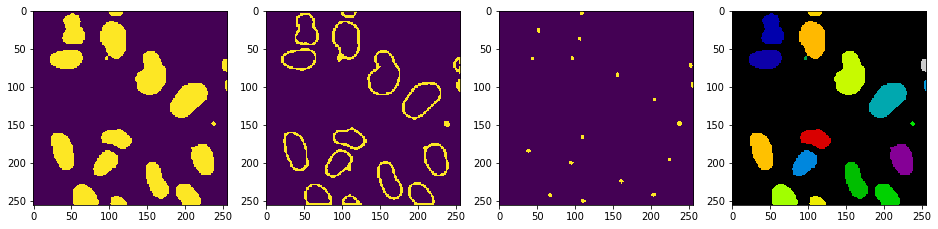

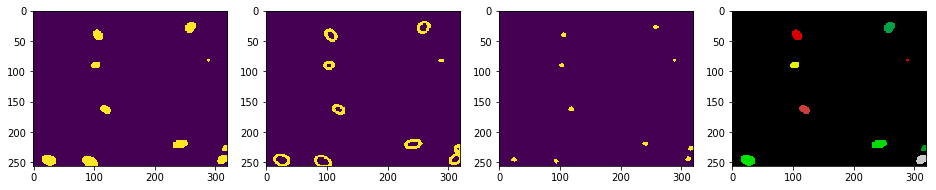

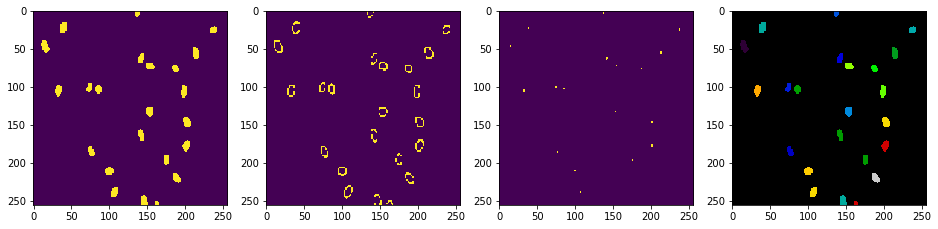

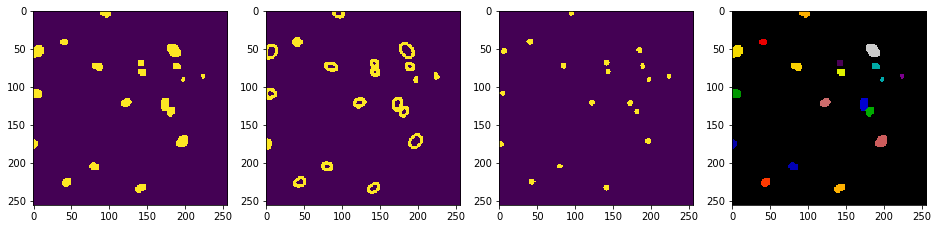

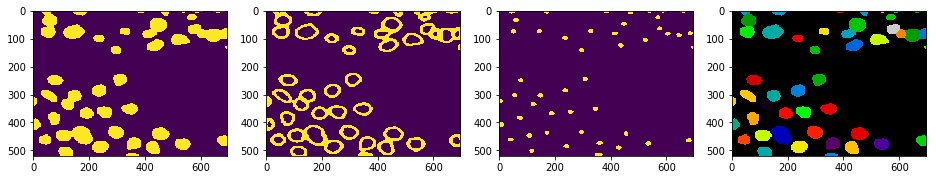

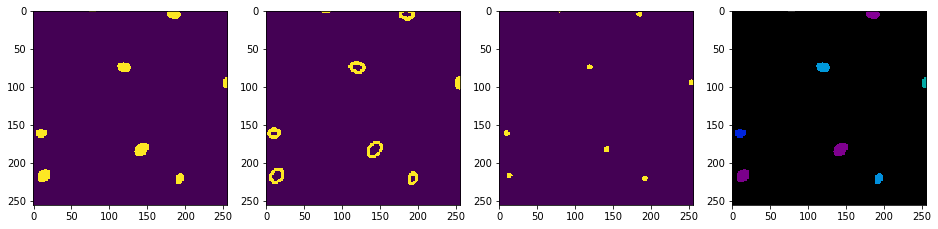

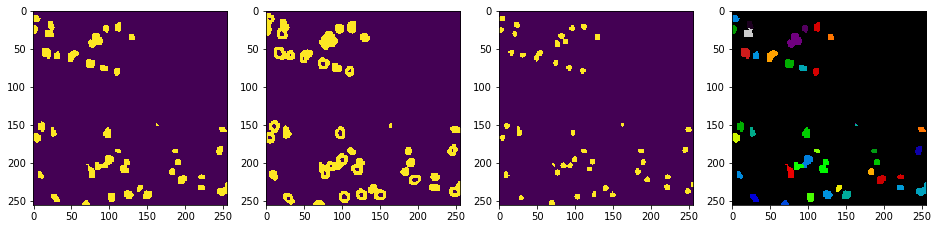

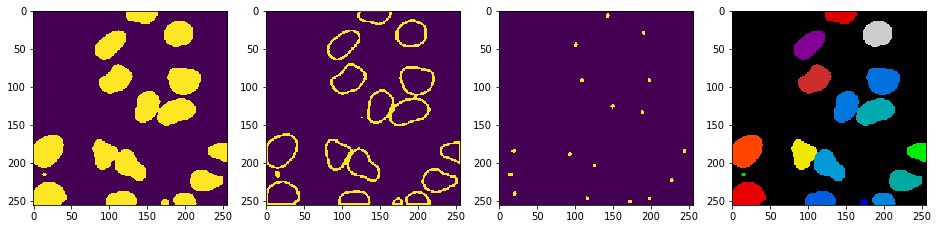

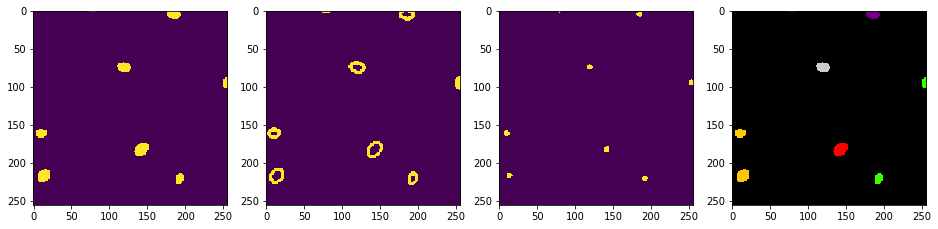

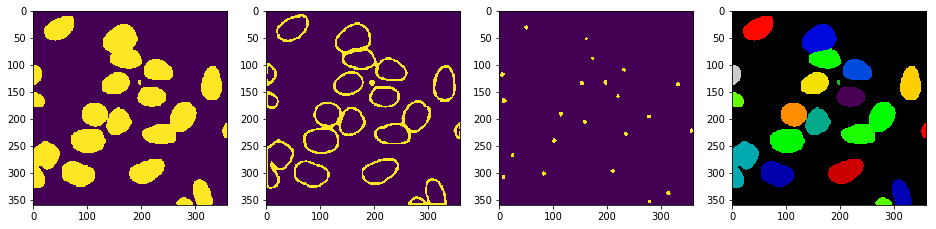

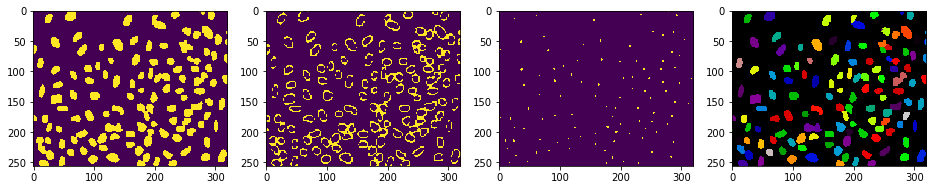

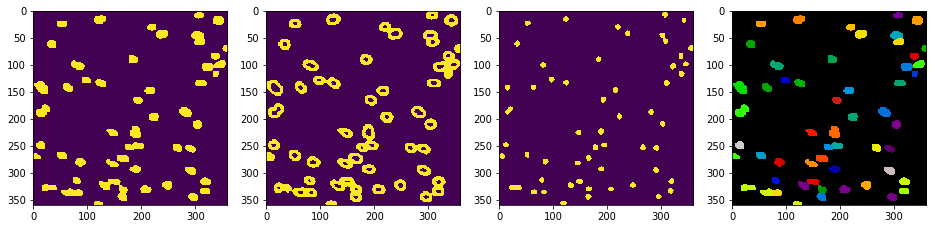

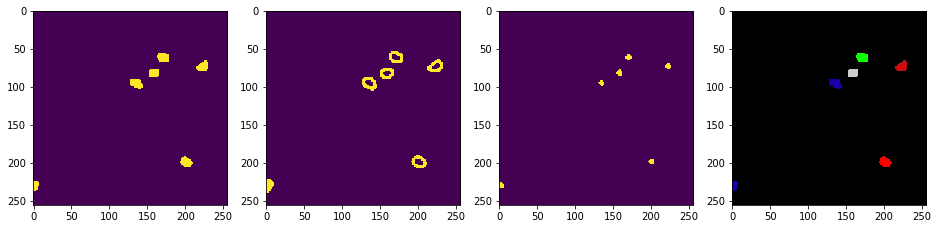

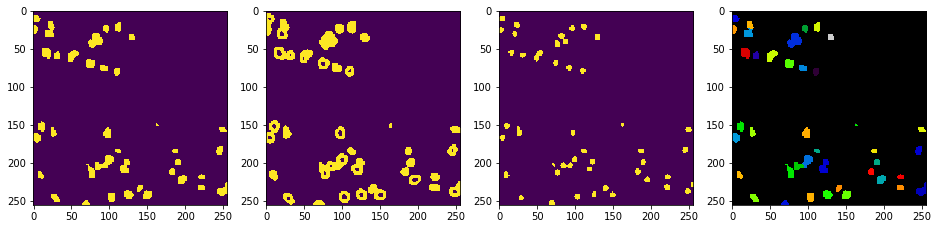

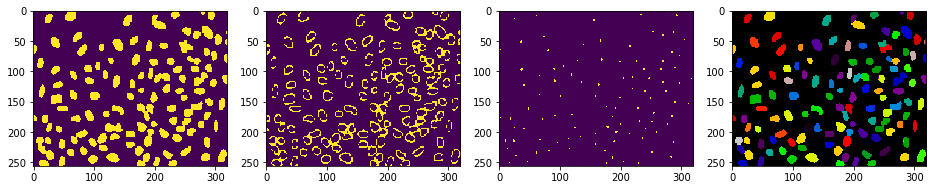

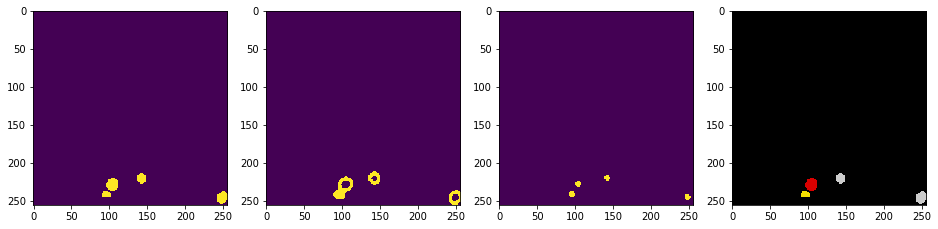

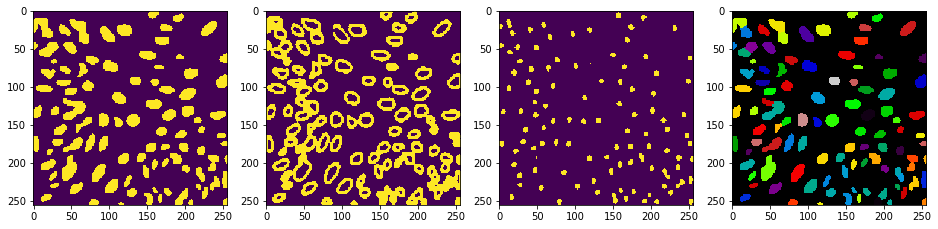

In [126]:
from tqdm import tqdm
import numpy as np
from scipy import ndimage as ndi
from scipy.stats import itemfreq
from sklearn.externals import joblib
from skimage.transform import resize
import skimage.morphology as morph

from preparation import train_valid_split

def watershed_combined(image, contour, center):
    mask = np.where(contour + image == 2, 0, image)

    distance = ndi.distance_transform_edt(mask)
    markers, nr_blobs = ndi.label(mask)
    labeled = morph.watershed(-distance, markers, mask=image)

    dropped, _ = ndi.label(image - (labeled > 0))
    dropped = np.where(dropped > 0, dropped + nr_blobs, 0)
    correct_labeled = dropped + labeled

    return correct_labeled
    
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/mask_thresholding')
contour_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/contour_thresholding')
center_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/center_thresholding')

for idx in np.random.choice(range(100),50):
    m = mask_threshold['binarized_images'][idx]
    t = contour_thresholding['binarized_images'][idx]
    c = center_thresholding['binarized_images'][idx]
    wc = watershed_combined(m,t,c)
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(t)
    plt.subplot(143)
    plt.imshow(c)   
    plt.subplot(144)
    plt.imshow(random_colors(wc),cmap='nipy_spectral') 
    plt.show()